## Class : C550-T301 Data Mining (2241-1)
## Name : Rajib Samanta
### Assignment : Week 6 ,8 & 10
### Term Project Milestone 1: Data Selection and EDA
### Topic : Personality Prediction

#### Data Source : https://www.kaggle.com/datasets/datasnaek/mbti-type/data

#### About Data File :
   The Myers–Briggs Type Indicator (MBTI) is a kind of psychological classification about human’s experience. 
     using four principal psychological functions, sensation, intuition, feeling, and thinking, 
        constructed by Katharine Cook Briggs and her daughter Isabel Briggs Myers.
   The Myers Briggs Type Indicator (or MBTI for short) is a personality type system that divides everyone. 
        into 16 distinct personality types across 4 axes:
        
            * Introversion (I) – Extroversion (E)
            * Intuition (N) – Sensing (S)
            * Thinking (T) – Feeling (F)
            * Judging (J) – Perceiving (P)
            

### Overview
  Organization needs to classify the individuals based on their personality traits. The availability of high dimensional and large amount of date has paved the way for increasing the effectiveness of marketing campaigns by targeting specific people. This will increase the popularity and attractiveness of products and services. Some common examples:
  1. Personalizing the online advertisement campaigns.
  2. Incorporate a personality-based approach to increase the attractiveness of recommended products.
  3. Personality based adaptations can also provide personalized visualization and better music recommendations.
  
  * In this project we will use machine learning to evaluate the MBTIs validity and ability to predict language styles and behaviour online.

In [52]:
# Import Libraries
# Import Libraries
import pandas as pd
import os
import numpy as np
#pip install textblob
from textblob import TextBlob
# pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
# pip install nltk
import nltk
from nltk.corpus import stopwords
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import collections
from collections import Counter
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder  #encoding categorical data to numerical
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier

In [53]:
# pip install xgboost

In [54]:
# Read the  dataset  file ('mbti_1.csv') from local:
directory = '/Users/rajibsamanta/Documents/Rajib/College/Sem6_fall_2023/Week6' 
# Set the working directory
os.chdir(directory)
print(os.getcwd())
# 1. Import the movie review data as a data frame and ensure that the data is loaded properly.

file_name = "mbti_1.csv"

# Load the dataset into a pandas DataFrame
df = pd.read_csv(file_name, delimiter=',')

# Display few records.
df.head()

/Users/rajibsamanta/Documents/Rajib/College/Sem6_fall_2023/Week6


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [55]:
# Describe the data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


    There are only 2 columns in the dataset
    Total no. of rows are 8675
    There are no null values present in the dataset
    One Disadvantage is that all values are textual, hence they have to be converted to numerical form 
    to train the ML model

In [56]:
#displays unique values in type column
df['type'].unique()   

array(['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'],
      dtype=object)

* It has 16 distinct personality types

Text(0.5, 1.0, 'Total posts for each personality type')

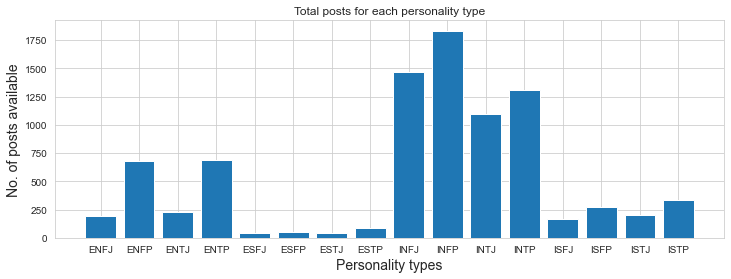

In [57]:
# Data visualization for no. of posts for each personality type
# Group by the data using type
df_total = df.groupby(['type']).count()

plt.figure(figsize = (12,4))
plt.bar(np.array(df_total.index), height = df_total['posts'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of posts available', size = 14)
plt.title('Total posts for each personality type')

We observe that some of the personality types has a lot more data than others, the most common Kaggle users personality is INFP (Introvert Intuition Feeling Perceiving).
We can consider for now that users who comment on social media more frequently are more intoverted, perceptive, and emotional.

In [58]:
#This function counts the no of words in each post of a user
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)

#this function counts the no of words per post out of the total 50 posts in the whole row
df['words_per_comment'] = df['posts'].apply(lambda x: len(x.split())/50)
df['variance_of_word_counts'] = df['posts'].apply(lambda x: var_row(x))
df.head()

,type,posts,words_per_comment,variance_of_word_counts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,135.2900
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,187.4756
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,180.6900
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,181.8324
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,196.4576


Since the original dataset only came with 2 features, the Type and 50 posts for each person, lets create additional features for exploring & analysing our dataset.Added two more parameter words per comments and Variance of words


/Users/rajibsamanta/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Lengths of all 50 Posts')

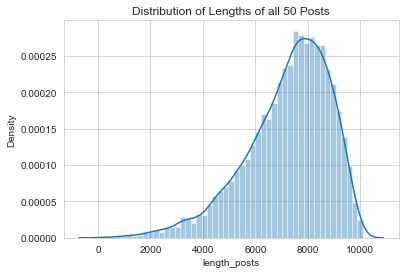

In [59]:
# Add length of the post 
df["length_posts"] = df["posts"].apply(len)
sns.distplot(df["length_posts"]).set_title("Distribution of Lengths of all 50 Posts")

We can see that most no of lengthly posts have between 7000-9000 words

In [60]:
#Finding the most common words in all posts.Top 20
words = list(df["posts"].apply(lambda x: x.split()))
words = [x for y in words for x in y]
Counter(words).most_common(20) 

[('I', 387957),
 ('to', 290168),
 ('the', 270699),
 ('a', 230918),
 ('and', 219498),
 ('of', 177853),
 ('is', 128804),
 ('you', 128750),
 ('that', 127221),
 ('in', 117263),
 ('my', 104561),
 ('it', 93101),
 ('for', 83057),
 ('have', 79784),
 ('with', 77131),
 ('but', 74729),
 ('be', 69317),
 ('are', 65034),
 ('like', 61390),
 ('not', 59496)]

In [61]:

# Convert the list to a DataFrame
df_words = pd.DataFrame(Counter(words).most_common(20) , columns=['Word', 'Count'])
df_words.head()


,Word,Count
0,I,387957
1,to,290168
2,the,270699
3,a,230918
4,and,219498


Text(0.5, 1.0, 'Posts with Common word count')

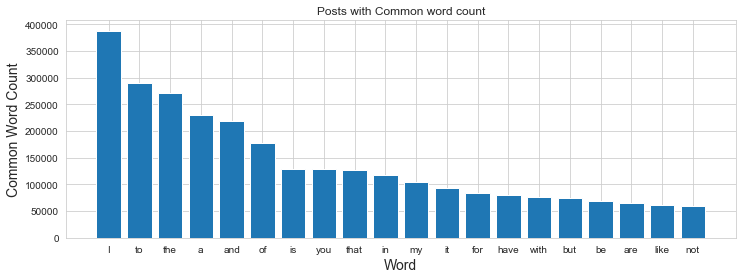

In [62]:
# Barplot for commonly used words.
plt.figure(figsize = (12,4))
plt.bar(df_words['Word'], height = df_words['Count'],)
plt.xlabel('Word', size = 14)
plt.ylabel('Common Word Count', size = 14)
plt.title('Posts with Common word count')

#### Next Steps:
#### Feature Engineering:
    Convert the text data into numerical features that machine learning models can understand. 
#### Label Encoding:
    Encode the categorical MBTI personality types into numerical labels. For example, convert "INFP" to 1,
    "ENFJ" to 2, and so on.
#### Data Splitting:
    Split the dataset into training, validation, and test sets. 
#### Model Selection:
    Choose a machine learning model suitable for text classification tasks. Common choices include logistic regression, support vector machines, random forests, and neural networks
#### Model Training:
    Train the selected model on the training dataset using the prepared text features and the corresponding MBTI labels.

# Week 8 and week 10

In [63]:
# Print dataset

df.head(10)

,type,posts,words_per_comment,variance_of_word_counts,length_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,135.2900,4652
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,187.4756,7053
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,180.6900,5265
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,181.8324,6271
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,196.4576,6111
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...,29.82,97.7200,8589
6,INFJ,"'No, I can't draw on my own nails (haha). Thos...",26.58,151.3664,7916
7,INTJ,'I tend to build up a collection of things on ...,24.46,174.7664,6900
8,INFJ,"I'm not sure, that's a good question. The dist...",14.76,207.1124,5325
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...,24.66,145.6704,7573


#### Counting the no. of users and posts in the given MBTI Kaggle dataset

In [64]:
def extract(posts, new_posts):
    for post in posts[1].split("|||"):
        new_posts.append((posts[0], post))

posts = []
df.apply(lambda x: extract(x, posts), axis=1)
print("Number of users", len(df))
print("Number of posts", len(posts))
print("5 posts from start are:")
posts[0:5]

Number of users 8675
Number of posts 422845
5 posts from start are:


[('INFJ', "'http://www.youtube.com/watch?v=qsXHcwe3krw"),
 ('INFJ', 'http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg'),
 ('INFJ',
  'enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks'),
 ('INFJ', 'What has been the most life-changing experience in your life?'),
 ('INFJ',
  'http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.')]

* It is inferenced that a lot of hyperlinks are presnt in these posts
* It is safe to assume that url links do not provide any real information about a user's personality, hence, we need to clean our dataset for these too.

#### Data cleaning & Pre-Processing :

In [65]:
def preprocess_text(df, remove_special=True):
    texts = df['posts'].copy()
    labels = df['type'].copy()

    #Remove links 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))
    
    #Keep the End Of Sentence characters
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', x + " "))
    
    #Strip Punctation
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[\.+]', ".",x))

    #Remove multiple fullstops
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^\w\s]','',x))

    #Remove Non-words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))
        #Convert posts to lowercase
    df["posts"] = df["posts"].apply(lambda x: x.lower())

    #Remove multiple letter repeating words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x)) 

    #Remove very short or long words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{0,3})?\b','',x)) 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{30,1000})?\b','',x))

    #Remove MBTI Personality Words - crutial in order to get valid model accuracy estimation for unseen data. 
    if remove_special:
        pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
        pers_types = [p.lower() for p in pers_types]
        p = re.compile("(" + "|".join(pers_types) + ")")
    
    return df

#Preprocessing of entered Text
data_set = pd.read_csv("/Users/rajibsamanta/Documents/Rajib/College/Sem6_fall_2023/Week6/mbti_1.csv")
new_df = preprocess_text(data_set, remove_special=True)

In [66]:
#Remove posts with less than X words
min_words = 15
print("Before : Number of posts", len(new_df)) 
new_df["no. of. words"] = new_df["posts"].apply(lambda x: len(re.findall(r'\w+', x)))
new_df = new_df[new_df["no. of. words"] >= min_words]

print("After : Number of posts", len(new_df))

Before : Number of posts 8675
After : Number of posts 8466


#### Feature Engineering

In [67]:
print(new_df.shape)


(8466, 3)


In [68]:
new_df.head()

,type,posts,no. of. words
0,INFJ,enfp intj moments sportscenter plays...,430
1,ENTP,finding lack these posts very alarming eo...,803
2,INTP,good course which know thats bles...,253
3,INTJ,dear intp enjoyed conversation other eos...,777
4,ENTJ,youre fired eostokendot thats another silly...,402


#### Splitting into Targets & Features:

In [69]:
# Converting MBTI personality (or target or Y feature) into numerical form using Label Encoding
# encoding personality type
# Encode the categorical MBTI personality types into numerical labels. For example, convert "INFP" to 1,"ENFJ" to 2, and so on
enc = LabelEncoder()
new_df['type of encoding'] = enc.fit_transform(new_df['type'])

target = new_df['type of encoding'] 

/var/folders/s5/r__yh4p17f12tlyfs6w_46xm0000gn/T/ipykernel_90320/336629569.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['type of encoding'] = enc.fit_transform(new_df['type'])


In [70]:
new_df.head(15)

,type,posts,no. of. words,type of encoding
0,INFJ,enfp intj moments sportscenter plays...,430,8
1,ENTP,finding lack these posts very alarming eo...,803,3
2,INTP,good course which know thats bles...,253,11
3,INTJ,dear intp enjoyed conversation other eos...,777,10
4,ENTJ,youre fired eostokendot thats another silly...,402,2
5,INTJ,eostokendot science perfect eostokendo...,245,10
6,INFJ,cant draw nails haha eostokendot those w...,970,8
7,INTJ,tend build collection things desktop th...,140,10
8,INFJ,sure thats good question eostokendot dist...,522,8
9,INTP,this position where have actually pe...,130,11


In [71]:
# In natural language processing, useless words are referred to as stop words. 
# The python natural language toolkit library provides a list of english stop words.
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [72]:
# we use stop_words='english' with CountVectorizer since this just counts the occurrences of each word in its vocabulary, extremely common words like ‘the’, ‘and’, etc. 
# will become very important features while they add little meaning to the text. This is an important step in pre-processing as our model can often be improved if you don’t take those words into account.
# Vectorizing the posts for the model and filtering Stop-words
vect = CountVectorizer(stop_words='english') 

# Converting posts (or training or X feature) into numerical form by count vectorization
train =  vect.fit_transform(new_df["posts"])
train.shape

(8466, 98555)

In [73]:
new_df.head()

,type,posts,no. of. words,type of encoding
0,INFJ,enfp intj moments sportscenter plays...,430,8
1,ENTP,finding lack these posts very alarming eo...,803,3
2,INTP,good course which know thats bles...,253,11
3,INTJ,dear intp enjoyed conversation other eos...,777,10
4,ENTJ,youre fired eostokendot thats another silly...,402,2


* So now there are 98555 features in our dataset for 8466 rows (users)

#### Model(s) Building

In [74]:
#Splitting into Train & Test Sets , 80-20 split
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, stratify=target, random_state=42)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(6772, 98555) (6772,) (1694, 98555) (1694,)


In [75]:
# Random Forest
accuracies = {}
random_forest = RandomForestClassifier(n_estimators=100, random_state = 1)
random_forest.fit(X_train, y_train)

# make predictions for test data
Y_pred = random_forest.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['Random Forest'] = accuracy* 100.0 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 39.20%


In [76]:
#XG boost Classifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

Y_pred = xgb.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['XG Boost'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 58.15%


In [77]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

Y_pred = logreg.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['Logistic Regression'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 57.73%


/Users/rajibsamanta/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 17.06%


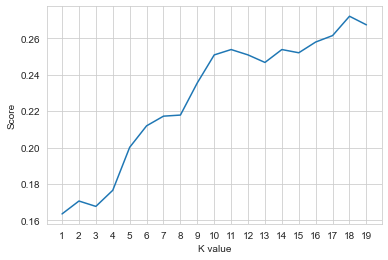

Maximum KNN Score is 27.21%


In [78]:
#KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 2)  # n_neighbors means k
knn.fit(X_train, y_train)

Y_pred = knn.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['KNN'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#try to find best k value
scoreList = []
for i in range(1,20):
    knn2 = KNeighborsClassifier(n_neighbors = i)  # n_neighbors means k
    knn2.fit(X_train, y_train)
    scoreList.append(knn2.score(X_test, y_test))
    
plt.plot(range(1,20), scoreList)
plt.xticks(np.arange(1,20,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

acc = max(scoreList)*100

print("Maximum KNN Score is {:.2f}%".format(acc))

In [79]:
#Gradient Descent
sgd = SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, y_train)

Y_pred = sgd.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['Gradient Descent'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 27.80%


In [80]:
# SVM Model
from sklearn.svm import SVC
svm = SVC(random_state = 1)
svm.fit(X_train, y_train)

Y_pred = svm.predict(X_test)

predictions = [round(value) for value in Y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['SVM'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 36.48%


In [81]:
#### Comparing Algorithms
pd.DataFrame.from_dict(accuracies, orient='index', columns=['Accuracies(%)'])

,Accuracies(%)
Random Forest,39.197166
XG Boost,58.146399
Logistic Regression,57.733176
KNN,17.060213
Gradient Descent,27.804014
SVM,36.481700


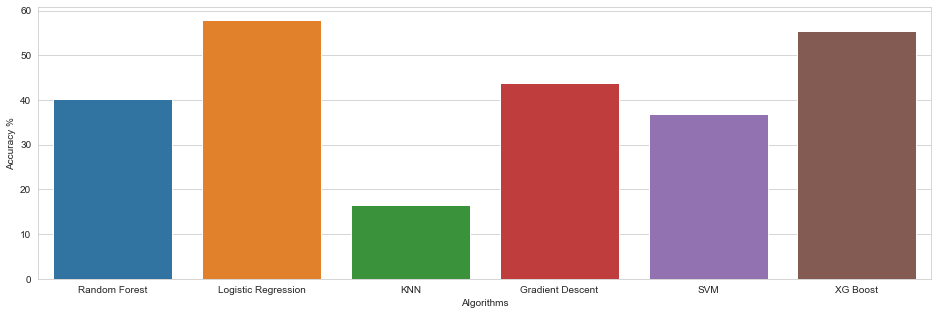

In [50]:
# Bar plot
sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.show()

* After comparing all the ML models, Logistic Regression model has highest accuracy 57.925072. So will consider this model as Personality Predictor.